In [441]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize
#v. 20221121.1

filedir = './data/frog-rod/'
outputdir = './output/frog-rod/'
filenames = ['42.ASC']
fs = 500                        # частота дискретизации, Гц
signal_scale = 1                # коэффициент масштабирования сигнала
signal_unit = 'pA'              # единица измерения сигнала
first_stim_start_time = 1       # начало первого стимула, с
period = 8                      # период следования стимулов, с
background_start_time = 5       # начало фоновой засветки, с
background_duration = 90        # длительность фоновой засветки, с
sign = -1                        # полярность {1:'стимулы вверх', -1:'стимулы вниз'}
low_cutoff = 0.1                # частота среза highpass фильтра, Гц
stims_to_delete = []            # номера неудачных стимулов (перечислить через запятую)
stims_to_export = []            # номера стимулов для экспорта в файл (пример: [(0, 2), 25] - с 0 по 2, 25)
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period
background_end_time = background_start_time + background_duration

In [442]:
# Чтение сигнала из файла(ов)

signal = []
filesizes = [] # количество точек в файлах
for filename in filenames:
    with open(filedir + filename, 'r', encoding='utf-8') as file:
        filesizes.append(0)
        file.readline()
        line = file.readline()
        while line and line[0] == '"':
            line = file.readline()
        signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
        filesizes[-1] += 1
        for line in file:
            signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
            filesizes[-1] += 1
signal = np.array(signal)

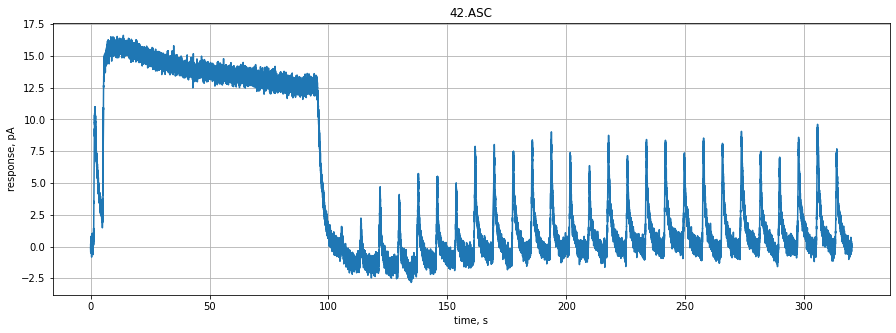

In [443]:
# Построение графика сигнала

n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(','.join(filenames))
ax.grid()

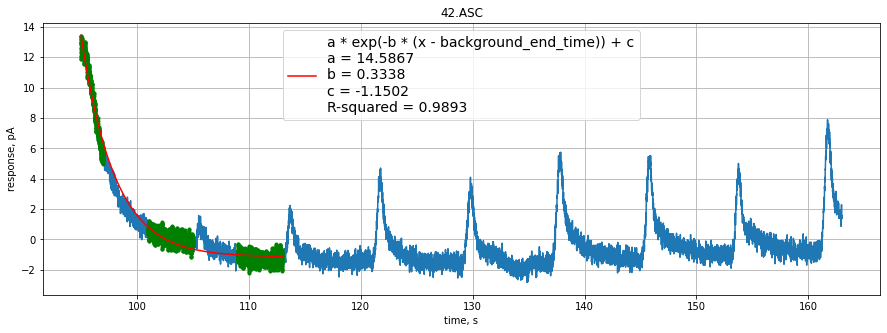

In [444]:
# Расчет нисходящей экспоненты
size = period // 2 * fs

# Для аппроксимации используется группа точек после конца засветки до after_background_start_time
begin = background_end_time * fs
end = after_background_start_time * fs
xs = [t[begin:end]]
ys = [signal[begin:end]]

# и еще 2 группы точек из хвостов 2 первых стимулов
stims_on_exp_cnt = 2
begin = after_background_start_time * fs + period * fs - size
end = begin + size
for i in range(stims_on_exp_cnt):
    xs.append(t[begin:end])
    ys.append(signal[begin:end])
    begin += period * fs
    end = begin + size
x = np.concatenate(xs)
y = np.concatenate(ys)

# Аппроксимация нисходящей экспоненты
def func(x, a, b, c):
    return a * np.exp(-b * (x - background_end_time)) + c
popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, x, y, [10, 1, 0])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию нисходящей экспоненты. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
begin = background_end_time * fs
end = after_background_start_time * fs + stims_on_exp_cnt * period * fs
exponent = func(t[begin:end], *popt)
rvalue = stats.linregress(y, func(x, *popt)).rvalue
r_squared = rvalue ** 2

fig, ax = plt.subplots()
ax.plot(t[begin:end + 50 * fs], signal[begin:end + 50 * fs])
ax.plot(x, y, 'g.')
ax.plot(t[begin:end], exponent, 'r', label=f'a * exp(-b * (x - background_end_time)) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(','.join(filenames))
ax.legend(prop={"size": 14})
ax.grid()

In [445]:
# Расчет количества и позиций стимулов

# Последний стимул в каждом файле исключается, так как нет гарантии, что длина файла будет кратна периоду стимулов.
# Если длина файла не кратна периоду, то последний стимул может быть обрезан концом файла.
stims_cnt = (filesizes[0] // fs - after_background_start_time) // period
begin = after_background_start_time
stims_t = []
for i in range(stims_cnt):
    stims_t.append(begin + i * period)
pos = 0
for i in range(1, len(filesizes)):
    file_stims_cnt = (filesizes[i] // fs - first_stim_start_time) // period
    stims_cnt += file_stims_cnt
    pos += filesizes[i - 1] // fs
    begin = pos + first_stim_start_time
    for j in range(file_stims_cnt):
        stims_t.append(begin + j * period)
stims_t = np.array(stims_t)

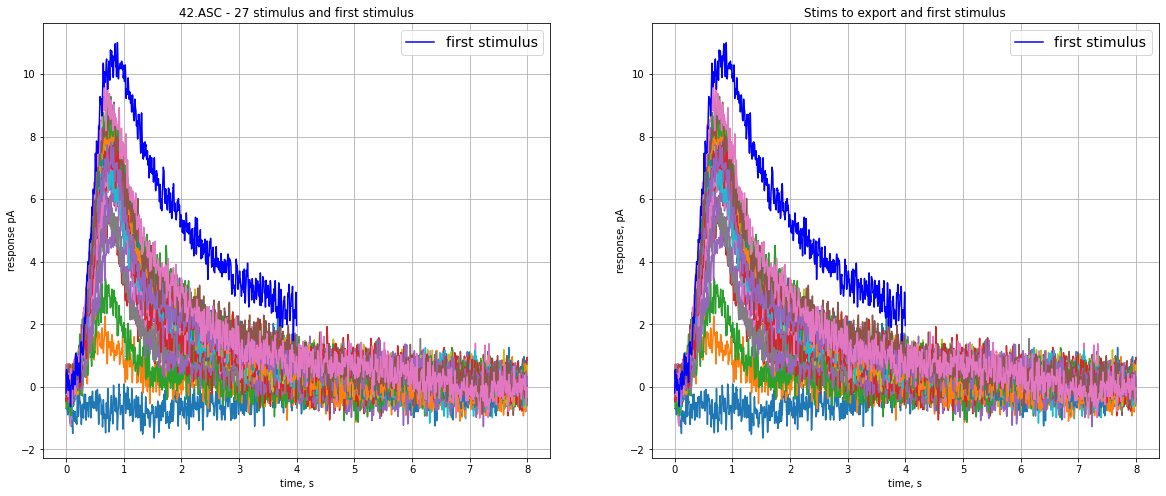

In [446]:
# Выделение стимулов и вычитание тренда из стимулов

stims = []

# вычитание экспоненты из первых exp_detrend_cnt стимулов
for i in range(stims_on_exp_cnt):
    begin = stims_t[i] * fs
    end = begin + period * fs
    begin1 = (stims_t[i] - background_end_time) * fs
    end1 = begin1 + period * fs
    stim = np.array(signal[begin:end] - exponent[begin1:end1])
    stims.append(stim)

# вычитание линейного тренда из остальных стимулов
prefix = fs // 5 # 0.2 секунды слева от стимула используются для расчета тренда
postfix = fs // 5 # последние 0.2 секунды стимула используются для расчета тренда
size = period * fs + prefix
for i in range(stims_on_exp_cnt, stims_cnt):
    begin = stims_t[i] * fs - prefix
    end = begin + size
    stim = np.array(signal[begin:end])
    temp_t = np.linspace(0, (size - 1), size)
    x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
    y = np.concatenate([stim[:prefix], stim[size - postfix:]])
    s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
    k, b = s[1], s[0]
    trend = k * temp_t + b
    stim = stim - trend
    stim = stim[prefix:]
    stims.append(stim)

# Первый (опорный) стимул без вычитания тренда
begin = first_stim_start_time * fs
end = background_start_time * fs
first_stim = np.array(signal[begin:end])
first_stim_max = first_stim.max()

size = period * fs
temp_t = np.linspace(0, period - 1 / fs, size)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
for stim in stims:
    ax1.plot(temp_t, stim)
end = (background_start_time - first_stim_start_time) * fs
ax1.plot(temp_t[:end], first_stim, 'b', label='first stimulus')
ax1.legend(prop={"size": 14})
ax1.set_xlabel('time, s')
ax1.set_ylabel('response ' + signal_unit)
ax1.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus and first stimulus')
ax1.grid()

numbers = set()
if not stims_to_export:
    numbers = set(range(stims_cnt))
else:
    for number in stims_to_export:
        if type(number) is tuple:
            numbers |= set(range(number[0], min(number[1] + 1, stims_cnt)))
        else:
            if number < stims_cnt:
                numbers.add(number)
stims_to_export = list(sorted(numbers))

for number in stims_to_export:
    ax2.plot(temp_t, stims[number])
end = (background_start_time - first_stim_start_time) * fs
ax2.plot(temp_t[:end], first_stim, 'b', label='first stimulus')
ax2.legend(prop={"size": 14})
ax2.set_xlabel('time, s')
ax2.set_ylabel('response, ' + signal_unit)
ax2.set_title('Stims to export and first stimulus')
ax2.grid()

Номер	Время	Максимум
0	2	1.2572
1	10	2.2967
2	18	3.4710
3	26	6.1288
4	34	5.7102
5	42	7.3265
6	50	7.0029
7	58	6.0780
8	66	8.5848
9	74	8.6662
10	82	8.1248
11	90	8.6132
12	98	9.2834
13	106	7.5909
14	114	6.8655
15	122	9.1008
16	130	7.4787
17	138	8.8260
18	146	8.5039
19	154	7.4367
20	162	9.0305
21	170	8.4527
22	178	9.1740
23	186	7.7982
24	194	7.8238
25	202	8.9188
26	210	9.8438


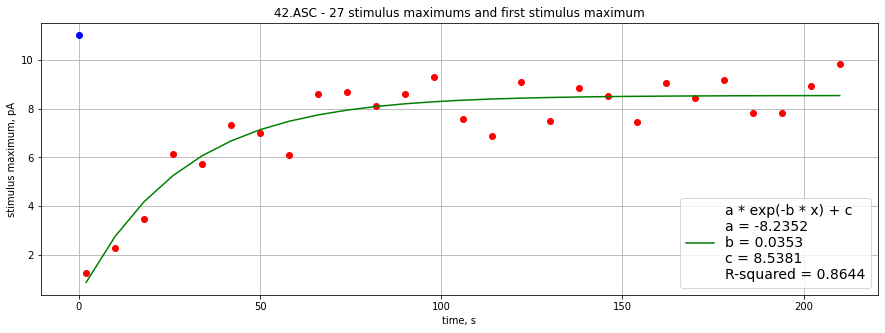

In [447]:
# Аппроксимация максимумов стимулов экспонентой
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

stims_maximums = np.array([stim.max() for stim in stims])

# Считается расстояние между началом первого импульса после фоновой засветки и ее концом
# График максимумов стимулов начинает строится в точке, равной рассчитанному расстоянию
stims_t -= background_end_time

print('Номер\tВремя\tМаксимум')
for i, (x, stim_maximum) in enumerate(zip(stims_t, stims_maximums)):
    print(f'{i}\t{x}\t{stim_maximum:.4f}')

# Удаление неудачных стимулов
stims_maximums = np.delete(stims_maximums, stims_to_delete)
stims_t = np.delete(stims_t, stims_to_delete)

# Аппроксимация
popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stims_t, stims_maximums, [-10, 0.01, 10])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
fit = func(stims_t, *popt)
rvalue = stats.linregress(stims_maximums, fit).rvalue
r_squared = rvalue ** 2

# Построение графика экспоненты
fig, ax = plt.subplots()
ax.plot(stims_t, stims_maximums, 'ro')
ax.plot(0, first_stim_max, 'bo')
ax.plot(stims_t, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - {stims_maximums.size} stimulus maximums and first stimulus maximum')
ax.legend(prop={"size": 14})
ax.grid()

In [448]:
# Сохранение результатов в файлы
from pathlib import Path

Path(outputdir).mkdir(parents=True, exist_ok=True)
# Сохранение максимумов стимулов
with open(f'{outputdir}{",".join(filenames)}_out.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write(f'Параметр экспоненты a\t{exp_a:.4f}\n')
    file.write(f'Параметр экспоненты b\t{exp_b:.4f}\n')
    file.write(f'Параметр экспоненты c\t{exp_c:.4f}\n')
    file.write(f'Постоянная времени 1/b\t{1 / exp_b:.4f}\n')
    file.write(f'R-squared\t{r_squared:.4f}\n')
    file.write('\n')
    file.write('time, с\tU, у.е\tфункция аппроксимации (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max}\n')
    for i in range(stims_maximums.size):
        file.write(f'{stims_t[i]}\t{stims_maximums[i]}\t{fit[i]}\n')

# Сохранение стимулов
with open(f'{outputdir}{",".join(filenames)}_resp.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write('\n')
    file.write('time, с\tОпорный\t')
    for number in stims_to_export:
        file.write(f'{number}\t')
    file.write('\n')
    size = first_stim.size
    temp_t = np.linspace(0, period - 1 / fs, size)
    for i in range(size):
        file.write(f'{temp_t[i]:.3f}\t{first_stim[i]}\t')
        for number in stims_to_export:
            file.write(f'{stims[number][i]}\t')
        file.write('\n')